# Import

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image  
import json
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Random seed

In [137]:
myseed = 724 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Read Json file and convert to JPEG image.


In [138]:
test_images = []
with open('60_data.json', 'r') as f:
    data = json.load(f) 

data = np.array(data)
data = (data-np.min(data))/(np.max(data)-np.min(data))
data = data.tolist()
for i in range (len(data)):
    data[i] = np.reshape(data[i], (28, 28))
    test_images.append(data[i])

test_imgs = copy.deepcopy(test_images)
test_imgs = np.array(test_imgs)
test_imgs = 255 * (test_imgs-np.min(test_imgs))/(np.max(test_imgs)-np.min(test_imgs))
for i in range(test_imgs.shape[0]):
    image = Image.fromarray(test_imgs[i])
    if image.mode == 'F':
        image = image.convert('L')
    image.save(f'./testing_data/{i}.jpg')
  
f.close()

test_images = np.array(list(test_images)).astype(np.float32)

# Custom Dataset

In [139]:
class CustomDataset(Dataset):
    
    def __init__(self, x, y, transform):
        self.transform = transform
        self.images = x
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        if self.transform is not None:
            image = self.transform(self.images[index])
        return image, self.labels[index]

# Dataloader

In [140]:
test_tfm = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
])
# test_loader = DataLoader(
#     datasets.MNIST(
#         "./data",
#         train=False,
#         download=True,
#         transform = test_tfm,
#     ),
#     batch_size=1,
#     shuffle=True,
# )

ground_truth = [0, 6, 4, 4, 5, 7, 3, 7]
test_dataset = CustomDataset(test_images ,ground_truth , test_tfm)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Neural Network

In [141]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Load Pretrain Model

In [142]:
model = Net().to(device)
model.load_state_dict(torch.load("mnist_model.pth", map_location="cpu"))
model.eval()
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


# FGSM Attack Function
perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇ 
x
​
 J(θ,x,y))

In [143]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
# epsilons = [0, .1, .2, .3]
def fgsm_attack(image, epsilon, data_gradient):
    sign_data_gradient = data_gradient.sign()
    perturbed_image = image + epsilon*sign_data_gradient
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image


def denormalize(batch, mean=[0.1307], std=[0.3081]):
    inverseTrans = transforms.Compose([ 
        transforms.Normalize(mean = (0.), std = (1/0.3081,)),
        transforms.Normalize(mean = (-0.1307,), std = (1.)),
    ])
    return inverseTrans(batch)
    # if isinstance(mean, list):
    #     mean = torch.tensor(mean).to(device)
    # if isinstance(std, list):
    #     std = torch.tensor(std).to(device)

    # return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

# Test

In [144]:
def criterion(pred, label):
    return F.cross_entropy(pred, label)
    # return F.nll_loss(pred, label)

def test(model, device, test_loader, epsilons):
    
    correct_num = 0
    adv_examples = []

    for batch in tqdm(test_loader):
        data, label = batch
        data, label = data.to(device), label.to(device)
        
        data.requires_grad = True

        output_logits = model(data)
        # init_prediction = output_logits.max(1, keepdim = True)[1]
        init_prediction = output_logits.argmax(dim=-1)

        # if init_prediction.item() != label.item():
        #     continue

        loss = criterion(output_logits, label)
        model.zero_grad()
        loss.backward()

        # Get data gradient value
        data_gradient = data.grad.data

        perturbed_data = fgsm_attack(data, epsilons, data_gradient)

        # data_denormalization = denormalize(data) 
        # perturbed_data = fgsm_attack(data_denormalization, epsilons, data_gradient)

        # perturbed_data_normalization = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        output_logits = model(perturbed_data)
        # output_logits = model(perturbed_data_normalization)

        # final_prediction = output_logits.max(1, keepdim=True)[1]
        final_prediction = output_logits.argmax(dim=-1)

        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (label.item(), final_prediction.item(), adv_ex))
        
        if final_prediction.item() == label.item():
            correct_num += 1
            # if epsilons == 0 and len(adv_examples) < 5:
            #     adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            #     adv_examples.append( (init_prediction.item(), final_prediction.item(), adv_ex) )
    
        # else:
        #     if len(adv_examples) < 5:
        #         adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        #         adv_examples.append( (init_prediction.item(), final_prediction.item(), adv_ex) )
           

    final_acc = correct_num/float(len(test_loader))
    print(f"Epsilon: {epsilons}\tTest Accuracy = {correct_num} / {len(test_loader)} = {final_acc}")

    return final_acc, adv_examples

# Run 

In [145]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

100%|██████████| 8/8 [00:00<00:00, 377.62it/s]


Epsilon: 0	Test Accuracy = 7 / 8 = 0.875


100%|██████████| 8/8 [00:00<00:00, 360.80it/s]


Epsilon: 0.05	Test Accuracy = 7 / 8 = 0.875


100%|██████████| 8/8 [00:00<00:00, 429.55it/s]


Epsilon: 0.1	Test Accuracy = 7 / 8 = 0.875


100%|██████████| 8/8 [00:00<00:00, 359.35it/s]


Epsilon: 0.15	Test Accuracy = 5 / 8 = 0.625


100%|██████████| 8/8 [00:00<00:00, 309.69it/s]


Epsilon: 0.2	Test Accuracy = 3 / 8 = 0.375


100%|██████████| 8/8 [00:00<00:00, 369.93it/s]


Epsilon: 0.25	Test Accuracy = 1 / 8 = 0.125


100%|██████████| 8/8 [00:00<00:00, 341.09it/s]

Epsilon: 0.3	Test Accuracy = 0 / 8 = 0.0


# Result

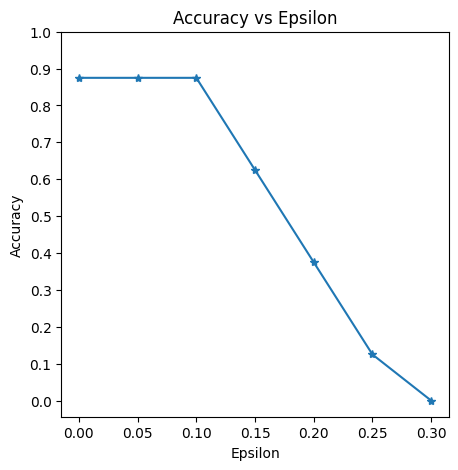

In [146]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Sample Adversarial Examples

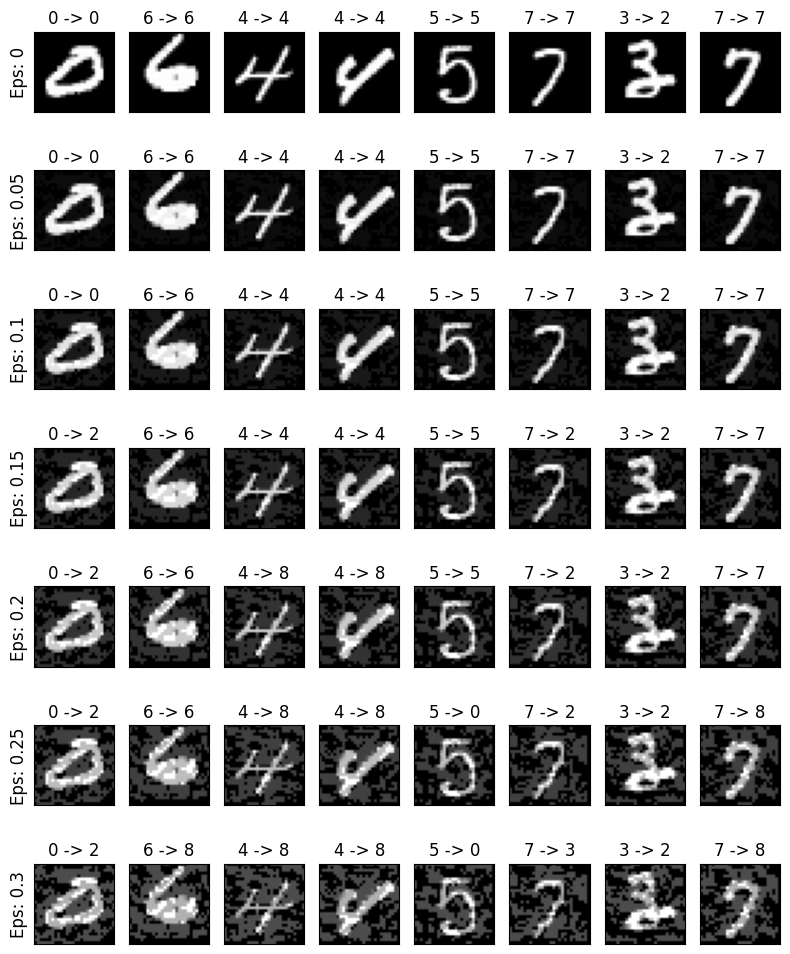

In [147]:
count = 0
plt.figure(figsize=(8,10))

for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        count += 1
        plt.subplot(len(epsilons), len(examples[i]), count)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=12)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0,right=1, left=0, bottom=0, top=1)
plt.show()